In [1]:
#Libraries 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Libraries for keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras import backend

#Libraries for cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

#Libraries for plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


/Users/apple/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Read the training dataset
dataset = pd.read_csv("train.csv")


In [3]:
#Display of top-5 entries in the dataset
dataset.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [4]:
#Dataset dimension
dataset.shape

(550068, 12)

In [5]:
#Data type of the dataset
dataset.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

/Users/apple/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


<function matplotlib.pyplot.show>

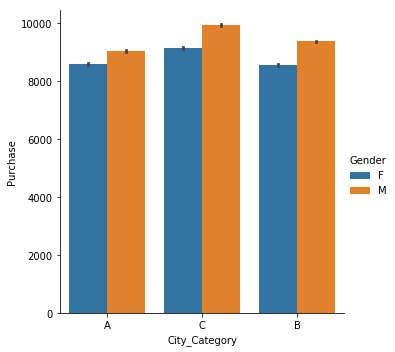

In [6]:
# Data Exploration and Plotting
sns.factorplot("City_Category", "Purchase", "Gender", data=dataset, kind="bar", legend = True) 
plt.show

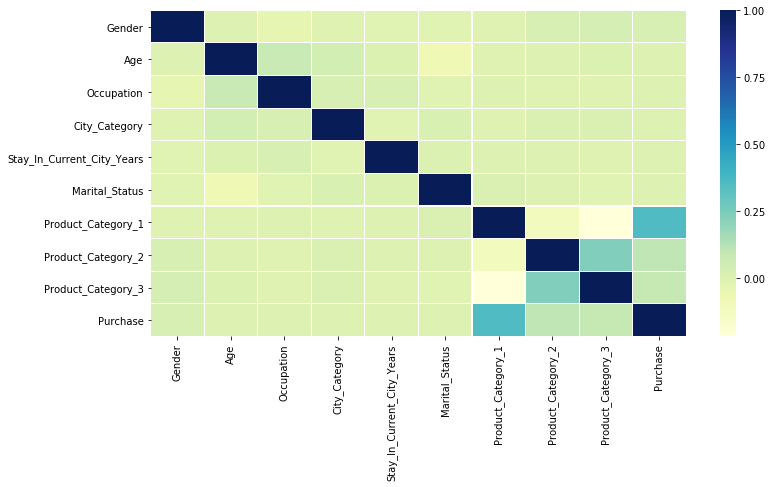

In [7]:
plt.figure(figsize=(12, 6))
dataset.drop(['User_ID', 'Product_ID'], axis=1, inplace=True)
corr = dataset.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu")

In [8]:
dataset.isnull().sum()

Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

In [9]:
dataset["Gender"].value_counts()

M    414259
F    135809
Name: Gender, dtype: int64

In [10]:
dataset["Age"].value_counts()


26-35    219587
36-45    110013
18-25     99660
46-50     45701
51-55     38501
55+       21504
0-17      15102
Name: Age, dtype: int64

In [11]:
dataset["City_Category"].value_counts()


B    231173
C    171175
A    147720
Name: City_Category, dtype: int64

In [49]:
#Data Preprocessing
dataset["Age"]=dataset["Age"].str.replace('0-17','15') #0 to 17 age range is stored as 15
dataset["Age"]=dataset["Age"].str.replace('55\+','60') #age above 55+ is considered as 60
new = dataset["Age"].str.split("-", n = 1, expand = True).astype(float) #retain the lower value in the age range and typecast it to float
dataset["Age"] = new[0]   
dataset["Stay_In_Current_City_Years"]=dataset["Stay_In_Current_City_Years"].str.replace('4\+','4') #consider stay in city as 4 years for people living more than 4 years        

In [51]:
#Missing category value replace it by 0,because we are not sure of the category type that they might belong to
dataset["Product_Category_2"].fillna(0, inplace = True) 
dataset["Product_Category_3"].fillna(0, inplace = True)

In [52]:
# Encode the categorical data to numeric value
df_encoded = pd.get_dummies(dataset, columns=['Gender','City_Category'], drop_first=True)

In [53]:
# Print top-5 enteries after encoding the data
df_encoded.head()

,User_ID,Product_ID,Age,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Gender_M,City_Category_B,City_Category_C
0,1000001,P00069042,15.0,10,2,0,3,0.0,0.0,8370,0,0,0
1,1000001,P00248942,15.0,10,2,0,1,6.0,14.0,15200,0,0,0
2,1000001,P00087842,15.0,10,2,0,12,0.0,0.0,1422,0,0,0
3,1000001,P00085442,15.0,10,2,0,12,14.0,0.0,1057,0,0,0
4,1000002,P00285442,60.0,16,4,0,8,0.0,0.0,7969,1,0,1


In [54]:
#Dimension of the encoded-data, we now have one additional column for the city_category
df_encoded.shape

(550068, 13)

In [55]:
#Check the columns after dummy encoding
df_encoded.columns

Index(['User_ID', 'Product_ID', 'Age', 'Occupation',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase', 'Gender_M',
       'City_Category_B', 'City_Category_C'],
      dtype='object')

In [56]:
df_encoded.dtypes

User_ID                         int64
Product_ID                     object
Age                           float64
Occupation                      int64
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
Gender_M                        uint8
City_Category_B                 uint8
City_Category_C                 uint8
dtype: object

In [57]:
#Store the encoded dataset as a copy
dataset = df_encoded


In [58]:
#Create independent variable - eliminating categorical data like user_id and product_id 
X = df_encoded.drop(['Purchase', 'User_ID','Product_ID'],axis = 1)

In [59]:
X.dtypes

Age                           float64
Occupation                      int64
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Gender_M                        uint8
City_Category_B                 uint8
City_Category_C                 uint8
dtype: object

In [60]:
#storing the dependent variable-purchase 
Y = dataset.iloc[:,9].values

In [61]:
#split the dataset into train and hold-out set. The split ratio is 80:20 [Train as 80 and hold out as 20]
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size = 0.2, random_state = 500)


C:\Users\meghn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Epoch 1/10
440054/440054 [==============================] - 15s 34us/step - loss: 26344998.2629 - mean_squared_error: 26344998.2629
Epoch 2/10
440054/440054 [==============================] - 15s 34us/step - loss: 19063504.7406 - mean_squared_error: 19063504.7406
Epoch 3/10
440054/440054 [==============================] - 16s 36us/step - loss: 18085555.2961 - mean_squared_error: 18085555.29610s - loss: 18091318.7787 - mean_squared_error: 18091318.
Epoch 4/10
440054/440054 [==============================] - 15s 35us/step - loss: 17870293.8180 - mean_squared_error: 17870293.8180
Epoch 5/10
440054/440054 [==============================] - 16s 35us/step - loss: 17775177.8803 - mean_squared_error: 17775177.8803
Epoch 6/10
440054/440054 [==============================] - 22s 51us/step - loss: 17714417.3347 - mean_squared_error: 17714417.3347
Epoch 7/10
440054/440054 [==============================] - 16s 37us/step - loss: 17668162.2136 - mean_squared_error: 17668162.2136
Epoch 8/10
440054/44

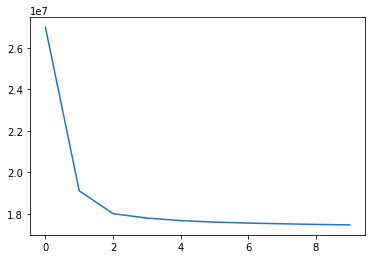

In [62]:
#Implement k-fold validation and the ANN model, here we are suing 5-fold validation
seed = 7
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
for train, test in kfold.split(X, Y):
    model = Sequential()
    model.add(Dense(50, input_dim=10, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
    hist = model.fit(xTrain, yTrain, epochs=10)
plt.plot(hist.history['mean_squared_error'])
plt.show()    
    

Epoch 1/10
440054/440054 [==============================] - 11s 25us/step - loss: 17087977.3942 - mean_squared_error: 17087977.3942
Epoch 2/10
440054/440054 [==============================] - 13s 29us/step - loss: 16946596.4516 - mean_squared_error: 16946596.4516
Epoch 3/10
440054/440054 [==============================] - 13s 30us/step - loss: 16809400.4931 - mean_squared_error: 16809400.4931
Epoch 4/10
440054/440054 [==============================] - 13s 31us/step - loss: 16657160.4028 - mean_squared_error: 16657160.4028
Epoch 5/10
440054/440054 [==============================] - 13s 30us/step - loss: 16488257.2636 - mean_squared_error: 16488257.2636
Epoch 6/10
440054/440054 [==============================] - 13s 30us/step - loss: 16327837.3587 - mean_squared_error: 16327837.3587
Epoch 7/10
440054/440054 [==============================] - 13s 30us/step - loss: 16207923.7108 - mean_squared_error: 16207923.7108
Epoch 8/10
440054/440054 [==============================] - 13s 30us/step - 

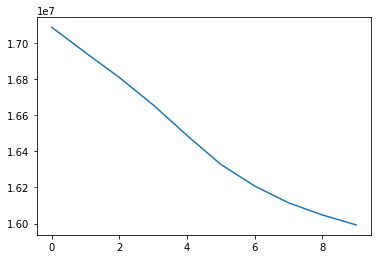

In [43]:
hist = model.fit(xTrain, yTrain, epochs=10)
plt.plot(hist.history['mean_squared_error'])
plt.show()